<a href="https://colab.research.google.com/github/leoroman1/DL_project/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"modality": {
	 "0": "FLAIR",
	 "1": "T1w",
	 "2": "t1gd",
	 "3": "T2w"
 },  
 "labels": {
	 "0": "background",
	 "1": "edema",
	 "2": "non-enhancing tumor",
	 "3": "enhancing tumour"
 }


# Google Drive connection

In [1]:
# connect to your drive with the dataset folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

## Zip file extraction

In [2]:
import os
import zipfile
from tqdm import tqdm

def extract_zip(zip_path, destination_path = "/content"):

    os.makedirs(destination_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc="Extracting", unit="file"):
            zip_ref.extract(member, path=destination_path)

    print(f"Extracted to: {destination_path}")


## Tar file extraction

In [3]:
import tarfile
from tqdm import tqdm
import os

def extract_tar(tar_path, destination_path = "/content"):

    os.makedirs(destination_path, exist_ok=True)

    with tarfile.open(tar_path, 'r:*') as tar:
        members = tar.getmembers()

        for member in tqdm(members, desc="Extracting", unit="file"):
            tar.extract(member, path=destination_path)

    print(f"Extracted to: {destination_path}")

## Zip and upload to drive

In [4]:
import shutil
import os

def save_zip_to_drive(folder_path, zip_name, destination_path = ''):

    zip_path = f"/content/{zip_name}.zip"

    shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=folder_path)
    print(f"Zipped folder to: {zip_path}")

    destination_path = f"/content/drive/MyDrive/{destination_path}"
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    shutil.move(zip_path, destination_path)
    print(f"Uploaded to Drive at: {destination_path}")


## Folder deletion from Colab

In [5]:
import shutil
import os

def delete_folders(folders_paths):

    for path in folders_paths:
        if os.path.exists(path):
            shutil.rmtree(path)
            print(f"Deleted: {path}")
        else:
            print(f"Not found: {path}")


## Folder renaming


In [6]:
import os

def rename_folder(folder_path, old_name, new_name):

    old_path_name = f"{folder_path}/{old_name}"
    new_path_name = f"{folder_path}/{new_name}"

    if os.path.exists(old_path_name):
        os.rename(old_path_name, new_path_name)
        print(f"{old_name} has been renamed to {new_name}")
    else:
        print(f"Folder not found: {old_path_name}")


## Copy files to another folder

In [7]:
import os
import shutil
from tqdm import tqdm

def copy_files_to_another_folder(source_folder, destination_folder, ids_list = 'all'):
    os.makedirs(destination_folder, exist_ok=True)

    if ids_list == 'all':
        files_to_copy = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    else:
        files_to_copy = [f"{id}.nii.gz" for id in ids_list]

    for filename in tqdm(files_to_copy, desc=f"Copying from {source_folder} to {destination_folder}", unit="file"):
        source_path = f"{source_folder}/{filename}"
        destination_path = f"{destination_folder}/{filename}"

        if not os.path.exists(source_path):
            print(f"Warning: {source_path} not found, skipping.")
            continue

        shutil.copy(source_path, destination_path)



## Apply a function to a folder

In [8]:
import os
import nibabel as nib
import numpy as np
import shutil
from tqdm import tqdm

def apply_function_to_folder(source_folder, destination_folder, function_to_apply):

    os.makedirs(destination_folder, exist_ok=True)

    for filename in tqdm(os.listdir(source_folder), desc=f"Applying function to files in {source_folder}", unit="file"):

        source_path = f"{source_folder}/{filename}"
        destination_path = f"{destination_folder}/{filename}"

        try:
            result_nii = function_to_apply(source_path)
            nib.save(result_nii, destination_path)
        except Exception as e:
            print(f"Error while processing file: {filename}: {e}")


# Data Exploration (to do)

# Preprocessing functions



## Retrieve data IDs to use

In [9]:
import os
import json

def retrieve_ids_list(dataset_json_path):

    with open(dataset_json_path, 'r') as f:
        data = json.load(f)

    data_ids = []

    for entry in data['training']:
        image_path = entry['image']
        filename = os.path.basename(image_path)
        image_id = filename.replace('.nii.gz', '')
        data_ids.append(image_id)

    print("Number of IDs extracted:", len(data_ids))
    print("First 5 IDs of the list:", data_ids[:5])
    return data_ids





## Cropping samples


In [10]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

import nibabel as nib

import nibabel as nib

def crop_file(file_path, height_range=(46, 190), width_range=(26, 202), depth_range=(6, 150)):

    nii_file = nib.load(file_path)
    data = nii_file.get_fdata()

    h_start, h_end = height_range
    w_start, w_end = width_range
    d_start, d_end = depth_range

    if data.ndim == 4:
        cropped_data = data[h_start:h_end, w_start:w_end, d_start:d_end, :]
    elif data.ndim == 3:
        cropped_data = data[h_start:h_end, w_start:w_end, d_start:d_end]

    cropped_nii = nib.Nifti1Image(cropped_data, affine=nii_file.affine, header=nii_file.header)
    return cropped_nii





## Split samples with almost only background

In [11]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

def split_samples_by_presence_of_tumor_labels(labels_folder, threshold=0.01):

    above_threshold_ids = []
    below_threshold_ids = []

    for id in tqdm(os.listdir(labels_folder), desc="Splitting samples by tumor labels presence: ", unit="file"):

        label_path = f"{labels_folder}/{id}"
        label_nii = nib.load(label_path)
        label_data = label_nii.get_fdata().astype(np.uint8)

        total_labels = np.prod(label_data.shape)
        non_background_labels = np.sum(label_data > 0)
        ratio = non_background_labels / total_labels

        id = id.split('.')[0]
        if ratio >= threshold:
            above_threshold_ids.append(id)
        else:
            below_threshold_ids.append(id)

    print(f"{len(above_threshold_ids)} samples above the threshold")
    print(f"{len(below_threshold_ids)} samples below the threshold")

    return above_threshold_ids, below_threshold_ids




## Keep only 2 modalities

In [12]:
import os
import nibabel as nib
import numpy as np
import shutil
from tqdm import tqdm

def extract_modalities(image_path, channels=[0, 2]):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"{image_path} does not exist")

    image_nii = nib.load(image_path)
    image_data = image_nii.get_fdata()
    selected_channels_data = image_data[:, :, :, channels]

    return nib.Nifti1Image(selected_channels_data, affine=image_nii.affine, header=image_nii.header)



## Normalization

In [13]:
import nibabel as nib
import numpy as np

def normalize_image(image_path):

    image_nii = nib.load(image_path)
    image = image_nii.get_fdata()

    normalized_image = np.zeros_like(image)

    for i in range(image.shape[-1]):
        channel_data = image[..., i]
        brain_region = channel_data[channel_data > 0]

        if brain_region.size == 0:
            normalized_image[..., i] = channel_data
        else:
            mean = brain_region.mean()
            std = brain_region.std()
            normalized_image[..., i] = (channel_data - mean) / (std + 1e-5)

    return nib.Nifti1Image(normalized_image, affine=image_nii.affine, header=image_nii.header)



# Preprocessing execution

In [83]:
# Extract dataset tar
dataset_path = '/content/drive/MyDrive/Task01_BrainTumour.tar'
extract_tar(dataset_path)

# Main folders now
images_folder = '/content/Task01_BrainTumour/imagesTr'
labels_folder = '/content/Task01_BrainTumour/labelsTr'

Extracting: 100%|██████████| 1277/1277 [01:15<00:00, 16.87file/s]  

Extracted to: /content


In [84]:
# Select IDs from the JSON
dataset_json_path = '/content/Task01_BrainTumour/dataset.json'
data_ids = retrieve_ids_list(dataset_json_path)

# Copy selected images to another folder
images_destination_folder = '/content/selected_imagesTr'
copy_files_to_another_folder(images_folder, images_destination_folder, data_ids)

# Copy selected labels to another folder
labels_destination_folder = '/content/selected_labelsTr'
copy_files_to_another_folder(labels_folder, labels_destination_folder, data_ids)

# Delete dataset folder to free space
colab_dataset_path = '/content/Task01_BrainTumour'
delete_folders([colab_dataset_path])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_destination_folder


Number of IDs extracted: 484
First 5 IDs of the list: ['BRATS_457', 'BRATS_306', 'BRATS_206', 'BRATS_449', 'BRATS_318']


Copying from /content/Task01_BrainTumour/imagesTr to /content/selected_imagesTr: 100%|██████████| 484/484 [00:44<00:00, 10.85file/s]
Copying from /content/Task01_BrainTumour/labelsTr to /content/selected_labelsTr: 100%|██████████| 484/484 [00:00<00:00, 2629.35file/s]


Deleted: /content/Task01_BrainTumour


In [85]:
# Crop images
images_destination_folder = '/content/cropped_imagesTr'
apply_function_to_folder(images_folder, images_destination_folder, crop_file)

# Crop labels
labels_destination_folder = '/content/cropped_labelsTr'
apply_function_to_folder(labels_folder, labels_destination_folder, crop_file)

# Delete folders to free space
delete_folders([images_folder, labels_folder])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_destination_folder


Applying function to files in /content/selected_imagesTr: 100%|██████████| 484/484 [10:58<00:00,  1.36s/file]
Applying function to files in /content/selected_labelsTr: 100%|██████████| 484/484 [00:48<00:00, 10.08file/s]


Deleted: /content/selected_imagesTr
Deleted: /content/selected_labelsTr


In [86]:
# Split samples with almost no tumor labels from others (could be used later)
above_threshold_ids, below_threshold_ids = split_samples_by_presence_of_tumor_labels(labels_folder)

# Put relevant images in another folder
rel_images_destination_folder = '/content/relevant_samples_imagesTr'
copy_files_to_another_folder(images_folder, rel_images_destination_folder, above_threshold_ids)

# Put relevant labels in another folder
rel_labels_destination_folder = '/content/relevant_samples_labelsTr'
copy_files_to_another_folder(labels_folder, rel_labels_destination_folder, above_threshold_ids)

# Put non relevant images in another folder
non_rel_images_destination_folder = '/content/non_relevant_samples/imagesTr'
copy_files_to_another_folder(images_folder, non_rel_images_destination_folder, below_threshold_ids)

# Put non relevant labels in another folder
non_rel_labels_destination_folder = '/content/non_relevant_samples/labelsTr'
copy_files_to_another_folder(labels_folder, non_rel_labels_destination_folder, below_threshold_ids)

# Upload non relevant samples zip to drive
non_rel_samples_path = '/content/non_relevant_samples'
save_zip_to_drive(non_rel_samples_path, 'non_relevant_samples')


# Delete past folders to free space
delete_folders([images_folder, labels_folder, non_rel_samples_path])

# Main folders now
images_folder = rel_images_destination_folder
labels_folder = rel_labels_destination_folder


Splitting samples by tumor labels presence: 100%|██████████| 484/484 [00:09<00:00, 53.24file/s]


415 samples above the threshold
69 samples below the threshold


Copying from /content/cropped_imagesTr to /content/relevant_samples_imagesTr: 100%|██████████| 415/415 [00:44<00:00,  9.39file/s]
Copying from /content/cropped_labelsTr to /content/relevant_samples_labelsTr: 100%|██████████| 415/415 [00:00<00:00, 5717.14file/s]
Copying from /content/cropped_imagesTr to /content/non_relevant_samples_imagesTr: 100%|██████████| 69/69 [00:08<00:00,  8.29file/s]
Copying from /content/cropped_labelsTr to /content/non_relevant_samples_labelsTr: 100%|██████████| 69/69 [00:00<00:00, 5466.28file/s]


Zipped folder to: /content/non_relevant_samples_imagesTr.zip
Uploaded to Drive at: /content/drive/MyDrive/non_relevant_samples/imagesTr
Zipped folder to: /content/non_relevant_samples_labelsTr.zip
Uploaded to Drive at: /content/drive/MyDrive/non_relevant_samples/labelsTr
Deleted: /content/cropped_imagesTr
Deleted: /content/cropped_labelsTr
Deleted: /content/non_relevant_samples_imagesTr
Deleted: /content/non_relevant_samples_labelsTr


In [87]:
# Keep just FLAIR and t1gt modalities
images_destination_folder = '/content/2channel_imagesTr'
apply_function_to_folder(images_folder, images_destination_folder, extract_modalities)

# Delete image folder to free space
delete_folders([images_folder])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_folder

Applying function to files in /content/relevant_samples_imagesTr: 100%|██████████| 415/415 [04:28<00:00,  1.55file/s]


Deleted: /content/relevant_samples_imagesTr


In [88]:
# Normalize per sample
images_destination_folder = '/content/normalized_imagesTr'
apply_function_to_folder(images_folder, images_destination_folder, normalize_image)

# Delete image folder to free space
delete_folders([images_folder])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_folder

Applying function to files in /content/2channel_imagesTr: 100%|██████████| 415/415 [03:21<00:00,  2.06file/s]

Deleted: /content/2channel_imagesTr


In [ ]:
# Move images and labels to a single final folder
final_images_destination_folder = '/content/preprocessed_dataset/imagesTr'
final_labels_destination_folder = '/content/preprocessed_dataset/labelsTr'
copy_files_to_another_folder(images_folder, final_images_destination_folder)
copy_files_to_another_folder(labels_folder, final_labels_destination_folder)

# Upload zip of final dataset to Drive
final_dataset_path = '/content/preprocessed_dataset'
save_zip_to_drive(final_dataset_path, 'preprocessed_dataset')

# Delete folders to free space
delete_folders([images_folder, labels_folder, final_dataset_path])


# Extract preprocessed dataset


In [14]:
# Unzip preprocessed dataset from Drive to Colab
preprocessed_dataset_path = '/content/drive/MyDrive/preprocessed_dataset.zip'
extract_zip(preprocessed_dataset_path)

# Main folder
images_folder = '/content/imagesTr'
labels_folder = '/content/labelsTr'

Extracting: 100%|██████████| 832/832 [01:00<00:00, 13.83file/s]

Extracted to: /content


# Model setup functions


## Split IDs into Train, Validaton and Test

In [15]:
import os
from sklearn.model_selection import train_test_split

def split_ids_into_train_val_test(images_folder, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1, seed=1748):

    ids = [f.replace('.nii.gz', '') for f in os.listdir(images_folder)]
    ids.sort()

    train_ids, val_test_ids = train_test_split(ids, test_size=(1 - train_ratio), random_state=seed)

    validation_size = validation_ratio / (validation_ratio + test_ratio)
    validation_ids, test_ids = train_test_split(val_test_ids, test_size=(1 - validation_size), random_state=seed)

    print(f"Total IDs count: {len(ids)}")
    print(f"Train IDs count: {len(train_ids)}")
    print(f"Validation IDs count: {len(validation_ids)}")
    print(f"Test IDs count: {len(test_ids)}")

    return train_ids, validation_ids, test_ids


## Extract input dimensions

In [16]:
import os
import nibabel as nib

def get_input_size(images_folder):

    first_image = sorted(os.listdir(images_folder))[0]
    image_path = os.path.join(images_folder, first_image)

    image_data = nib.load(image_path).get_fdata()

    height, width, depth, modalities = image_data.shape

    print(f"Height: {height}, Width: {width}, Depth: {depth}, Modalities: {modalities}")

    return height, width, depth, modalities


# U-Net model

In [17]:
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

input_layer = layers.Input(shape=(144, 176, 2))

# Encoder (Downsampling path)
c1 = conv_block(input_layer, 16)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Decoder (Upsampling path)
u6 = layers.UpSampling2D((2, 2))(c5)
u6 = layers.Concatenate()([u6, c4])
c6 = conv_block(u6, 128)

u7 = layers.UpSampling2D((2, 2))(c6)
u7 = layers.Concatenate()([u7, c3])
c7 = conv_block(u7, 64)

u8 = layers.UpSampling2D((2, 2))(c7)
u8 = layers.Concatenate()([u8, c2])
c8 = conv_block(u8, 32)

u9 = layers.UpSampling2D((2, 2))(c8)
u9 = layers.Concatenate()([u9, c1])
c9 = conv_block(u9, 16)

output_layer = layers.Conv2D(4, (1, 1), activation='softmax')(c9)

# Data generator for slices

In [18]:
import os
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import Sequence

class BrainTumor2DSliceGenerator(Sequence):
    def __init__(self, images_folder, labels_folder, ids, batch_size=36, slice_step=8, shuffle=True):

        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.slice_step = slice_step
        self.ids = sorted(ids)
        self.index_list = self._create_index_list()
        if self.shuffle:
            np.random.shuffle(self.index_list)

    def _create_index_list(self):
        index_list = []
        for id in self.ids:
            image_path = os.path.join(self.images_folder, id + '.nii.gz')
            image_data = nib.load(image_path).get_fdata()
            for i in range(0, image_data.shape[2], self.slice_step):
                index_list.append((id, i))
        return index_list

    def __len__(self):
        return int(np.ceil(len(self.index_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.index_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = []
        batch_y = []
        for id, slice_idx in batch_indexes:
            image_data = nib.load(os.path.join(self.images_folder, id + '.nii.gz')).get_fdata(dtype=np.float32)
            label_data = nib.load(os.path.join(self.labels_folder, id + '.nii.gz')).get_fdata()

            image_slice = image_data[:, :, slice_idx, :]
            label_slice = label_data[:, :, slice_idx]

            batch_X.append(image_slice.astype(np.float32))
            batch_y.append(label_slice.astype(np.int32))

        return np.array(batch_X), np.array(batch_y).astype(np.int32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.index_list)

# Loss functions

## Sparse Categorical Class Entropy Loss

In [19]:
import tensorflow as tf
from tensorflow.keras.losses import Dice, SparseCategoricalCrossentropy

scce_loss = SparseCategoricalCrossentropy(from_logits=False)

## Dice Loss

In [20]:
import tensorflow as tf
from tensorflow.keras.losses import Dice

number_of_classes = 4

def dice_loss(y_true, y_pred):

    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=number_of_classes)

    return Dice(axis=(1, 2))(y_true_one_hot, y_pred)

## Combo Losses

### Sparse Categorical Cross Entropy Loss and Dice Loss

In [21]:
def combo_scce_dice_loss(y_true, y_pred, alpha=0.5):
    scce_loss_value = scce_loss(y_true, y_pred)
    dice_loss_value = dice_loss(y_true, y_pred)
    return alpha * scce_loss_value + (1 - alpha) * dice_loss_value


# Metrics

## Intersection over Union

In [22]:
from tensorflow.keras.metrics import MeanIoU

number_of_classes = 4

iou_metric = MeanIoU(
    num_classes=number_of_classes,
    sparse_y_true=True,
    sparse_y_pred=False,
    name="IoU"
)

## F1 Score per class

In [23]:
import tensorflow as tf

def f1_score_per_class_fn(class_id):
    @tf.function  # ensures TensorFlow traces once and reuses
    def f1_score(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, tf.int32)

        pred_labels = tf.equal(y_pred, class_id)
        true_labels = tf.equal(y_true, class_id)

        tp = tf.reduce_sum(tf.cast(pred_labels & true_labels, tf.float32))
        fp = tf.reduce_sum(tf.cast(pred_labels & ~true_labels, tf.float32))
        fn = tf.reduce_sum(tf.cast(~pred_labels & true_labels, tf.float32))

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        return f1
    return f1_score


f1_score_edema = f1_score_per_class_fn(1)
f1_score_non_enhancing_tumor = f1_score_per_class_fn(2)
f1_score_enhancing_tumor = f1_score_per_class_fn(3)


# Callbacks


## Drive checkpoint saver

In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/dice/epoch_{epoch:02d}.keras',  # customize as needed
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

# Model setup

## Training from scratch

In [25]:
# Split IDs into train, test and validation (default ratio is 80, 10, 10)
train_ids, validation_ids, test_ids = split_ids_into_train_val_test(images_folder)


Total IDs count: 415
Train IDs count: 332
Validation IDs count: 41
Test IDs count: 42


In [26]:
# Get input size (care, in our case the net is 4 layers deep, so every dimension except the modalities must be divisible by 16. The general rule is to be divisible by 2^n for a n layers U-Net).
# In our case Depth won't be used being our U-Net 2D
height, width, depth, modalities = get_input_size(images_folder)


Height: 144, Width: 176, Depth: 144, Modalities: 2


In [27]:
# Initialize train and validation data

train_batch_size = 144
train_slice_step = 8

validation_batch_size = 144
validation_slice_step = 8

train_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    train_ids,
    train_batch_size,
    train_slice_step,
    shuffle=True,
)

validation_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    validation_ids,
    validation_batch_size,
    validation_slice_step,
    shuffle=True,
)


In [28]:
# Initialize model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(
    optimizer='adam',
    loss=combo_scce_dice_loss,
    metrics=[iou_metric]
)

# Fit model
history = model.fit(train_data_gen,
          validation_data=validation_data_gen,
          epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 65s/step - IoU: 0.1904 - loss: 0.6399  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 2999s 71s/step - IoU: 0.1916 - loss: 0.6363 - val_IoU: 0.3368 - val_loss: 0.3850
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2964s 69s/step - IoU: 0.3526 - loss: 0.3731 - val_IoU: 0.3623 - val_loss: 0.3583
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2997s 70s/step - IoU: 0.5225 - loss: 0.3440 - val_IoU: 0.6245 - val_loss: 0.3275
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2951s 70s/step - IoU: 0.6297 - loss: 0.3253 - val_IoU: 0.6555 - val_loss: 0.3186
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2967s 70s/step - IoU: 0.6605 - loss: 0.3188 - val_IoU: 0.6768 - val_loss: 0.3140


In [29]:
# Save completed model
import os
import shutil
from tensorflow.keras.models import Model # Import Model

model_folder_drive = '/content/drive/MyDrive/the_final_models'
model_filename = 'combo1.keras'
temp_model_path = f'/content/{model_filename}' # Save to a temporary location

# Save the model to the temporary location
model.save(temp_model_path)
print(f"Model saved temporarily to: {temp_model_path}")

# Create the target directory in Drive if it doesn't exist
os.makedirs(model_folder_drive, exist_ok=True)

# Define the final destination path in Drive
final_model_path = os.path.join(model_folder_drive, model_filename)

# Move the saved model file to Google Drive
shutil.move(temp_model_path, final_model_path)
print(f"Model moved to Drive at: {final_model_path}")


# Save history
import json
import os

history_filepath = '/content/drive/MyDrive/final_histories/combo1.json'
os.makedirs(os.path.dirname(history_filepath), exist_ok=True)
with open(history_filepath, 'w') as f:
    json.dump(history.history, f)

Model saved temporarily to: /content/combo1.keras
Model moved to Drive at: /content/drive/MyDrive/the_final_models/combo1.keras


## Training from saved model

In [28]:
# Load saved model
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/the_final_models/combo2.keras'

model = load_model(model_path, custom_objects={
    'combo_scce_dice_loss': combo_scce_dice_loss,
    'iou_metric': iou_metric,})

# Fit model
history = model.fit(
          train_data_gen,
          validation_data=validation_data_gen,
          epochs=15,
          initial_epoch=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 62s/step - IoU: 0.7254 - loss: 0.3017  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 2826s 67s/step - IoU: 0.7254 - loss: 0.3016 - val_IoU: 0.6958 - val_loss: 0.3112
Epoch 12/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2778s 66s/step - IoU: 0.7256 - loss: 0.3023 - val_IoU: 0.7091 - val_loss: 0.3048
Epoch 13/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2720s 64s/step - IoU: 0.7381 - loss: 0.2986 - val_IoU: 0.7098 - val_loss: 0.3049
Epoch 14/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2737s 65s/step - IoU: 0.7475 - loss: 0.2956 - val_IoU: 0.6989 - val_loss: 0.3053
Epoch 15/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2758s 65s/step - IoU: 0.7376 - loss: 0.2966 - val_IoU: 0.7003 - val_loss: 0.3055


In [29]:
# Save completed model
import os
import shutil
from tensorflow.keras.models import Model # Import Model

model_folder_drive = '/content/drive/MyDrive/the_final_models'
model_filename = 'combo3.keras'
temp_model_path = f'/content/{model_filename}' # Save to a temporary location

# Save the model to the temporary location
model.save(temp_model_path)
print(f"Model saved temporarily to: {temp_model_path}")

# Create the target directory in Drive if it doesn't exist
os.makedirs(model_folder_drive, exist_ok=True)

# Define the final destination path in Drive
final_model_path = os.path.join(model_folder_drive, model_filename)

# Move the saved model file to Google Drive
shutil.move(temp_model_path, final_model_path)
print(f"Model moved to Drive at: {final_model_path}")


# Save history
import json
import os

history_filepath = '/content/drive/MyDrive/final_histories/combo3.json'
os.makedirs(os.path.dirname(history_filepath), exist_ok=True)
with open(history_filepath, 'w') as f:
    json.dump(history.history, f)

Model saved temporarily to: /content/combo3.keras
Model moved to Drive at: /content/drive/MyDrive/the_final_models/combo3.keras


## Test model

In [30]:
# Initialize test data generator

test_batch_size = 144
test_slice_step = 8

test_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    test_ids,
    batch_size=test_batch_size,
    slice_step=test_slice_step,
    shuffle=False
)

In [42]:
model_path = '/content/drive/MyDrive/the_final_models/combo2.keras'

model = load_model(model_path, custom_objects={
    'combo_scce_dice_loss': combo_scce_dice_loss,
    'iou_metric': iou_metric,})

In [31]:
# This will return a list of metric values in the same order as in model.compile()
test_results = model.evaluate(test_data_gen, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 179s 28s/step - IoU: 0.6417 - loss: 0.3225


In [36]:
import json
import os

results_dict = {name: float(value) for name, value in zip(model.metrics_names, test_results)}

results_path = '/content/drive/MyDrive/final_results/combo1/test_metrics3.json'
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results_dict, f, indent=4)


## Prediction exemple

In [ ]:
# Load model
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/checkpoints/scce/epoch_23.keras'
model = load_model(
    model_path,
    compile=False
)

In [33]:
print(test_ids)

['BRATS_360', 'BRATS_243', 'BRATS_474', 'BRATS_191', 'BRATS_307', 'BRATS_419', 'BRATS_077', 'BRATS_385', 'BRATS_447', 'BRATS_461', 'BRATS_087', 'BRATS_280', 'BRATS_151', 'BRATS_440', 'BRATS_156', 'BRATS_032', 'BRATS_003', 'BRATS_253', 'BRATS_294', 'BRATS_140', 'BRATS_168', 'BRATS_400', 'BRATS_258', 'BRATS_454', 'BRATS_268', 'BRATS_368', 'BRATS_145', 'BRATS_386', 'BRATS_162', 'BRATS_018', 'BRATS_216', 'BRATS_426', 'BRATS_247', 'BRATS_017', 'BRATS_028', 'BRATS_349', 'BRATS_135', 'BRATS_221', 'BRATS_082', 'BRATS_462', 'BRATS_356', 'BRATS_421']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


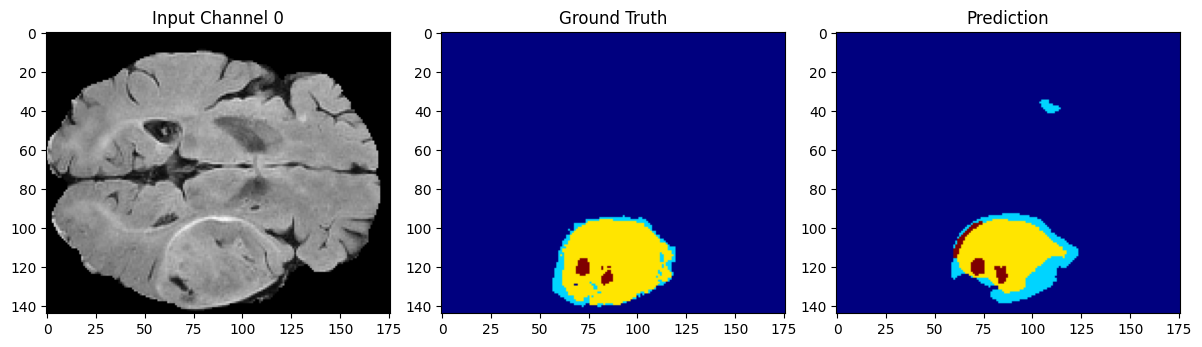

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Load one patient image + label
img_path = '/content/imagesTr/BRATS_243.nii.gz'
label_path = '/content/labelsTr/BRATS_243.nii.gz'

img = nib.load(img_path).get_fdata()
label = nib.load(label_path).get_fdata()

slice_index = 60  # choose a relevant axial slice

# Preprocess input
input_slice = img[:, :, slice_index, :2]  # shape: (H, W, 2)
input_slice = np.expand_dims(input_slice, axis=0)  # add batch dim -> (1, H, W, 2)

# Predict
pred = model.predict(input_slice)  # shape: (1, H, W, num_classes)
pred_label = np.argmax(pred[0], axis=-1)  # shape: (H, W)

# Plot result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_slice[0, :, :, 0], cmap='gray')
plt.title('Input Channel 0')

plt.subplot(1, 3, 2)
plt.imshow(label[:, :, slice_index], cmap='jet')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(pred_label, cmap='jet')
plt.title('Prediction')

plt.tight_layout()
plt.show()


## Clear session


In [ ]:
del model
del train_data_gen
del validation_data_gen
del history

In [33]:
import tensorflow.keras.backend as K
K.clear_session()


In [34]:
import gc
gc.collect()


0

# Result analysis (to do)

# ???

In [ ]:
import os
import nibabel as nib
import numpy as np

def compute_class_weights(label_dir, ids_list, num_classes=4):
    class_counts = np.zeros(num_classes, dtype=np.float64)
    total_voxels = 0

    for pid in ids_list:
        label_path = os.path.join(label_dir, pid + '.nii.gz')
        label = nib.load(label_path).get_fdata().astype(np.int32)
        for c in range(num_classes):
            class_counts[c] += np.sum(label == c)
        total_voxels += np.prod(label.shape)

    class_freq = class_counts / total_voxels
    # Avoid division by zero
    class_freq = np.clip(class_freq, 1e-6, None)

    # Compute weights as inverse frequency
    class_weights = 1.0 / class_freq
    # Normalize weights to sum to 1
    class_weights /= np.sum(class_weights)

    return class_weights

    num_classes = 4
weights = compute_class_weights(label_dir, train_ids, num_classes)
class_weights = np.round(weights, 3)  # Round to 3 decimals
print("Class weights:", class_weights)

In [ ]:
def sparse_focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.nn.softmax(y_pred)

        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred + 1e-6)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss